In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install bnlp-toolkit

     |████████████████████████████████| 1.2 MB 33.6 MB/s 
     |████████████████████████████████| 23.9 MB 17.4 MB/s 
     |████████████████████████████████| 743 kB 40.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
import joblib
import pandas as pd
import numpy as np
import re
from bnlp.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

punkt not found. downloading...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
lr_model_encoder=joblib.load(r"/content/drive/MyDrive/AutoEncoders/lr_file_encoder.pkl")
print(dir(lr_model_encoder))

['C', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_feature_names', '_check_n_features', '_estimator_type', '_get_param_names', '_get_tags', '_more_tags', '_predict_proba_lr', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', 'class_weight', 'classes_', 'coef_', 'decision_function', 'densify', 'dual', 'fit', 'fit_intercept', 'get_params', 'intercept_', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_features_in_', 'n_iter_', 'n_jobs', 'penalty', 'predict', 'predict_log_proba', 'predict_proba', 'random_state', 'score', 'set_params', 'solver', 'sparsify', 'tol', 'verbose', 'warm_start']


In [5]:
label_auth=pd.read_csv(r'/content/drive/MyDrive/AutoEncoders/LabeledAuthentic-7K.csv', nrows=3067)
label_fake=pd.read_csv(r'/content/drive/MyDrive/AutoEncoders/LabeledFake-1K.csv', nrows=995)
label_auth.drop(['source','relation'], axis=1, inplace=True)
label_fake.drop(['source','relation','F-type'], axis=1, inplace=True)
df=pd.concat([label_auth, label_fake], axis=0)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df['label']=np.where(df['label']==0.0, 0, 1)
df.tail()
df=df.sample(frac=1).reset_index(drop=True)
print(df.shape)
df.head()

(4062, 7)


,articleID,domain,date,category,headline,content,label
0,1405,jagonews24.com,2018-09-20 18:24:28,Politics,বাম জোটের মিছিলে পুলিশের বাধা,বাম গণতান্ত্রিক জোটের নির্বাচন কমিশন (ইসি) কার...,1
1,453,somoynews.tv,2018-09-20 15:02:14,National,'বিচারপতি সিনহা স্বীকার করেছেন হুমকির মুখে দেশ...,বিএনপির সিনিয়র যুগ্ম মহাসচিব রুহুল কবির রিজভী ...,1
2,2792,ittefaq.com.bd,2018-09-19 18:20:22,Sports,হংকংয়ের ওপেনিং জুটিতেই কাঁপছে ভারত,ভারতের দেয়া ২৮৬ রানের লক্ষ্য তাঁড়া করতে নেমে দ...,1
3,923,banglanews24.com,2018-09-23 10:22:48,Miscellaneous,মাকড়সার দখলে গ্রিক উপকূল!,গ্রিসের দ্বীপশহর আইতোলিকোতে সম্প্রতি ঘটে গেছে ...,1
4,362,bengalbeats.com,2019-02-12T21:20:33+00:00,Entertainment,তাহসানের কথায় গানকে বিদায় দিয়ে অভিনয় শুরু করতে...,যুক্তরাষ্ট্রের লস অ্যাঞ্জেলেসের স্টেপলস সেন্টা...,0


In [6]:
def preprocess(data):
    """This function is for preprocessing of the news contents. It removes punctuations, English characters and both of Bangla
    and English numerals. It tokenizes all the words and also removes stopwords.
    
    Args: 
        The Entire Dataframe
    Returns:
        Preprocessed news corpuses in a list of lists
    """
    corpus=[]
    for i in range(0, len(data)):
        x=re.sub('[^\u0980-\u09FF]',' ',data['content'][i])
        x=re.sub('[a-zA-Z0-9]+', ' ', x)
        x=re.sub('[০১২৩৪৫৬৭৮৯]+', ' ', x)
        x=x.split()
        x=[w for w in x if w not in set(stopwords)]
        x=' '.join(x)
        corpus.append(x)
    
    return corpus

In [7]:
corpus=preprocess(df)
corpus[16:20]

['লনডন মতিনিধিবাকশালী সরকারের ফেসিবাদী পরোয়ানা বৃহত্তর জামায়াতের বিএনপি শাখায় চলমান বিশৃংখলার প্রেক্ষিতে বিএনপি শাখা পরিতেগ কল্যান পার্টিতে যোগদানের কথা চিন্তা বিএনপি শাখার আওলাদে আমীর জাতীয়তাবাদী শক্তির ভবিষ্যত মালিক শহীদ প্রেসিডেন্ট জিয়াউর রহমানের যোগ্য উত্তরসুরী বড় গনতন্ত্র তারেক জিয়া লনডনে তারেক জিয়ার ঘনিষ্ঠ সুত্র মারফত তথ্য মতিকণ্ঠের হাতে এসেছে তারেক জিয়ার ঘনিষ্ঠ সুত্র নাম প্রকাশ শর্তে জানিয়েছেন বিএনপির অবস্থা বড় গনতন্ত্র অত্যন্ত হতাশ কল্যান পার্টিতে যোগদানের কথা ভাবছেন ঘনিষ্ঠ সুত্র তারেক জিয়া দেশ ছাড়ার বৃহত্তর জামায়াতের বিএনপি শাখাকে মজবুত বলীয়ান তুলেছিলেন গ্রামে গঞ্জে পানের দোকানেও হাওয়া ভবনের নাম বললে শতে দশ টেকা চান্দা আদায় স্বর্নালী বিগত বর্তমান বিএনপি শাখায় জেলায় জেলায় কোন্দল মারামারি হানাহানি অপরের পুটুতে অংগুলি চালাচালি তারেক জিয়া লনডনে বৃস্টি ছাতা খুলেন ছাতার নিচে একতা বদ্ধ বিএনপি দুর দল কনট্রল কঠিন বিভক্ত বিএনপি বড় গনতন্ত্র আশাহত আবেগঘন কণ্ঠে ঘনিষ্ঠ সুত্র সেদিন তারেক জিয়া দেশে ফুন মেরে জিজ্ঞাসা বাকশাল নামে পরোয়ানা বাইর করল দেশে প্রতিবাদে জ্বালাও প

In [8]:
hashing=HashingVectorizer(n_features=5000, ngram_range=(1, 3))
X=hashing.fit_transform(corpus).toarray()
y=df['label'].values
X.shape, y.shape

((4062, 5000), (4062,))

In [9]:
from tensorflow.keras.models import load_model
encoder=load_model('/content/drive/MyDrive/AutoEncoders/encoder_eff.h5')

In [10]:
X_encode=encoder.predict(X)

In [11]:
lr_pred=lr_model_encoder.predict(X_encode)
lr_pred[0:5]

array([1, 1, 1, 1, 0])

In [12]:
accuracy_score(y, lr_pred)

0.9734121122599705

In [13]:
print(classification_report(y, lr_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       995
           1       0.97      1.00      0.98      3067

    accuracy                           0.97      4062
   macro avg       0.98      0.95      0.96      4062
weighted avg       0.97      0.97      0.97      4062



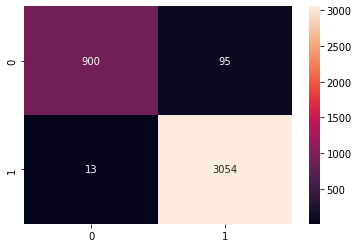

In [14]:
sns.heatmap(confusion_matrix(y, lr_pred), annot=True, fmt='g')
plt.show()

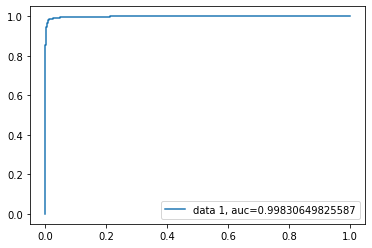

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba=lr_model_encoder.predict_proba(X_encode)[::,1]
fpr, tpr, _=roc_curve(y,  y_pred_proba)
auc=roc_auc_score(y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [21]:
!pip install plot-metric

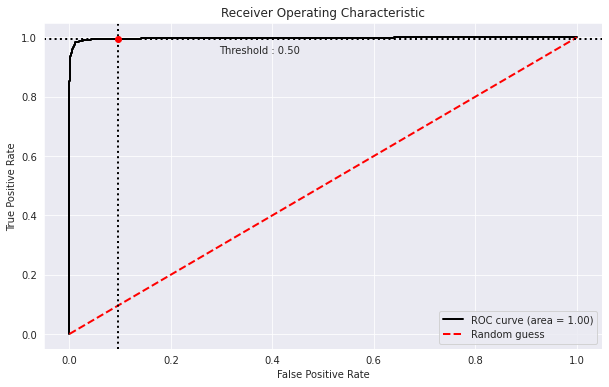

In [22]:
from plot_metric.functions import BinaryClassification
bc=BinaryClassification(y, y_pred_proba, labels=["Fake", "Real"])

plt.figure(figsize=(10, 6))
bc.plot_roc_curve()
plt.show()

In [23]:
encoder.evaluate(X, X)

127/127 [==============================] - 51s 396ms/step - loss: 7.3835e-05


7.383489719359204e-05